# <center>Задание 5.</center>

Нелинейная система описывается следующим выражением:
$$\begin{array}{rcl} y(n) = \sum_{k=1}^{K-1} a_k X(n - k) + b_k X(n - k) | X(n - k) |^{2} + c_k X(n - k) | X(n - k) |^{4} \end{array}$$

с некоторыми ненулевыми коэффициентами $a$,$b$ и $c$ которые задаются случайно.

Необходимо построить адаптивный фильтр, оценивающий данные коэффициенты системы в условиях шумов. Подразумевается, что оценивающий фильтр не знает об истинных значениях коэффциентов.
Задачей адаптивного фильтра является минимизация мощности ошибки $e$ в соответсвии со структурной схемой:

<img src='1.png'>

Требуется составить математические уравнения для определения коэффициентов адаптивного фильтра и написать простую программу в Matlab или на языке C, показывающую верность указанных уравнений на произвольных тестовых данных.



## Решение.

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
#функция, формирующая сиграл X
def X(x):
    real = np.sin(x) ** 2 
    imag = np.cos(x + 0.3)
    return complex(real, imag)

In [64]:
#описание нелинейной системы
def Y(K, N):
    
    h0 = [np.random.uniform(low=0, high=1, size=N)][0].T
    h1 = [np.random.uniform(low=0, high=1, size=N)][0].T
    h2 = [np.random.uniform(low=0, high=1, size=N)][0].T
    
    """print("real h0 = ")
    print(h0)
    print("real h1 = ")
    print(h1)
    print("real h2 = ")
    print(h2)"""
    
    Y = np.array(np.zeros(len(K)), dtype=complex)
    
    sum = 0
    nonl = 0
    
    for k in np.arange(len(K)):
        sum = complex(0, 0)                   
        for n in np.arange(N):
            #sum += (a[k] * X(n - k) + b[k] * X(n - k) * np.power(np.abs(X(n - k)), 2) + 
                    #c[k] * X(n - k) * np.power(np.abs(X(n - k)), 4))
            
            sum += complex(h0[n] * X(k - n).real, h0[n] * X(k - n).imag) + \
                h1[n] * pow(abs(complex(h2[n] * X(k).real, h2[n] * X(k).imag)), n)
            
            #nonl += h1[n] * pow(abs(complex(h2[n] * X(k).real, h0[n] * X(k).imag)), n)
            
            #print(nonl)
        Y[k] = sum
        
        
        
        
    

    return Y

### Подготовим данные для обучения
Сгенерируем данные $Y$, которые будут являться вектором истинных ответов

In [65]:
K_train = np.array(np.arange(10))
N = 10
y_train = Y(K_train, N)

print('\n Y[:5] = ') 
y_train[:5], N_train.shape, y_train.shape


 Y[:5] = 


(array([2.46443365+0.6239325j , 3.4897345 +0.94578129j,
        4.68976739+0.39808312j, 2.63461926-0.51561083j,
        3.18281131-0.95525457j]), (10,), (10,))

Опишем модель, которой будем аппроксимировать функционал, описывающий нелинейную систему:

$$\begin{array}{rcl} \acute{y}(n) = \sum_{k=1}^{K-1} \hat{a} X(n - k) + \hat{b} X(n - k) | X(n - k) |^{2} + \hat{c} X(n - k) | X(n - k) |^{4} \end{array}$$

In [70]:
def Y_predict(K, N, h0, h1, h2):
    
    Y = np.array(np.zeros(len(K)), dtype=complex)
    sum = 0
    for k in np.arange(len(K)):
        sum = complex(0, 0)                   
        for n in np.arange(N):
            #sum +=  * X(n - k) + b * X(n - k) * np.power(np.abs(X(n - k)), 2) + c * X(n - k) * np.power(np.abs(X(n - k)), 4)
            sum += complex(h0 * X(k - n).real, h0 * X(k - n).imag) + \
                h1 * pow(abs(complex(h2 * X(k).real, h2 * X(k).imag)), n)
        Y[k] = sum

    return Y

In [71]:
y_pred = Y_predict(N_train, K, 1, 1, 1)
y_train, y_pred

(array([2.46443365+0.6239325j , 3.4897345 +0.94578129j,
        4.68976739+0.39808312j, 2.63461926-0.51561083j,
        3.18281131-0.95525457j, 4.98830195-0.51664166j,
        2.8154061 +0.39696921j, 2.89311804+0.94560841j,
        5.08614237+0.62485961j, 3.00515063-0.27038224j]),
 array([22.87540541+1.10618953j, 14.24741656+0.38485101j,
        47.94392278-0.69031775j, 27.3313485 -1.13081155j,
        13.31792135-0.53164243j, 53.19455819+0.55631629j,
        30.15215717+1.13280038j, 12.97447086+0.66779303j,
        51.38505771-0.41118016j, 31.02360665-1.1121162j ]))

Опишем оптимизируемый функционал:

Задача: найти такие веса $a$, $b$ и $c$, чтобы при прогнозе  $\acute{y}_k = \hat{a} X(n - k) + \hat{b} X(n - k) | X(n - k) |^{2} + \hat{c} X(n - k) | X(n - k) |^{4}$ минимизировать квадратичную ошибку:

$$SE(a, b, c) = \sum_{k=1}^K(y_k - \acute{y}_k)^2 \rightarrow min_{a,b,c}$$

Делать мы это будем с помощью градиентного спуска, численно посчитав частные производные функции $SE(a, b, c)$ по весам в модели – $a$, $b$ и $c$.
Итеративную процедуру обучени будем задаваться простыми формулами обновления весов (меняем веса так, чтобы делать небольшой, пропорционально малой константе $\eta$, шаг в сторону антиградиента функции):

$$\begin{array}{rcl} a^{(t+1)} = a^{(t)} -\eta \frac{\partial SE}{\partial a} |_{t} \\  b^{(t+1)} = b^{(t)} -\eta \frac{\partial SE}{\partial b} |_{t} \\ c^{(t+1)} = c^{(t)} -\eta \frac{\partial SE}{\partial c} |_{t} \end{array}$$
    

In [95]:
#оптимизируемый функционал

#квадрат ошибки
def f_MSE(y, K, N, h0, h1, h2):
    return np.sum((y - Y_predict(K, N, h0, h1, h2))**2)


def Batch_Gradient(y_train, N, K, a = 1, b = 1, c = 1, 
                   leaning_rate = .001, h = .0005, observational = 0.00001, printing = True):
    """
    :param y_train: вектор истинных ответов
    :param N: параметр модели аппроксимации
    :param K: параметр моедли аппроксимации
    :param a: оцениваемый параметр (вес модели)
    :param b: оцениваемый параметр (вес модели)
    :param c: оцениваемый параметр (вес модели)
    :param leaning_rate: шаг градиентного спуска
    :param h: delta(x) - шаг для численного расчета частной производной функции в окрестности точки Y(x),
                         малая величина
    :observational: точность вычисления или разность между предыдущим и текущим значением веса (малая велчина)
    :printing: флаг печати промежуточных значений расчета
    :return: оценки параметров a, b, c
    """
    MSE = []
    MSE.append(f_MSE(y_train, N, K, a, b, c))
    
    for i in np.arange(10000):
        a_old = a
        b_old = b
        c_old = c
        
        a -= leaning_rate * (f_MSE(y_train, N, K, a + h, b, c) - f_MSE(y_train, N, K, a, b, c)) / h
        b -= leaning_rate * (f_MSE(y_train, N, K, a, b + h, c) - f_MSE(y_train, N, K, a, b, c)) / h
        c -= leaning_rate * (f_MSE(y_train, N, K, a, b, c + h) - f_MSE(y_train, N, K, a, b, c)) / h
        
        MSE.append(f_MSE(y_train, N, K, a, b, c))
        if (printing):
            print("Iteration {0}: MSE = {1:.6f}, a = {2:.6f}, b = {3:.6f}, c = {4:.6f}".format(i, MSE[i], a, b, c))
        
        if (np.abs(a_old - a) < observational) and (np.abs(b_old - b) < observational) and \
        (np.abs(c_old - c) < observational) and (np.abs(MSE[i] - MSE[i - 1]) < observational):
            return MSE, a, b, c
            #break
            

In [111]:
MSE, a, b, c = Batch_Gradient(y_train=y_train, N=N_train, K=K, leaning_rate=.001, h=.0005, observational=.001)

Iteration 0: MSE = 196.676656, a = 0.559701, b = 0.867672, c = 0.924989
Iteration 1: MSE = 29.696940, a = 0.392687, b = 0.817403, c = 0.896336
Iteration 2: MSE = 5.668019, a = 0.329397, b = 0.798280, c = 0.885278
Iteration 3: MSE = 2.216238, a = 0.305476, b = 0.790977, c = 0.880898
Iteration 4: MSE = 1.722633, a = 0.296498, b = 0.788162, c = 0.879054
Iteration 5: MSE = 1.652849, a = 0.293191, b = 0.787050, c = 0.878171
Iteration 6: MSE = 1.643236, a = 0.292037, b = 0.786584, c = 0.877654
Iteration 7: MSE = 1.641955, a = 0.291699, b = 0.786364, c = 0.877276
Iteration 8: MSE = 1.641748, a = 0.291671, b = 0.786237, c = 0.876951


In [112]:
y_pred = Y_predict(N_train, K, a, b, c)
y_train[:5], y_pred[:5]

(array([5.53681491, 6.5913066 , 5.17378525, 5.02871023, 5.9582612 ]),
 array([5.58659726, 6.17481344, 5.38843928, 5.19199573, 5.53767598]))

In [109]:
def plotMovingAverage(SE):
        
    plt.figure(figsize=(15,5))


    plt.plot(SE, label="Squared error")
    plt.legend(loc="upper left")
    plt.grid(True)


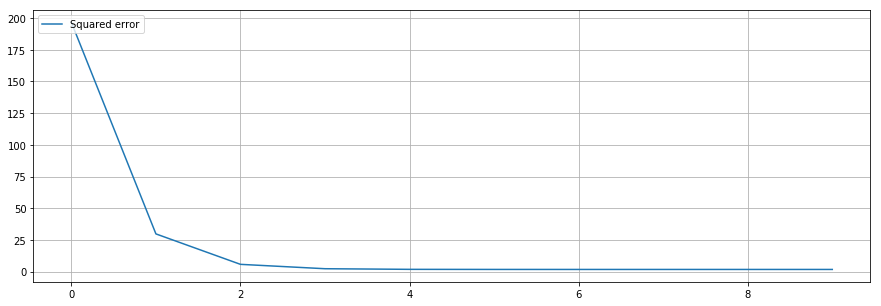

In [113]:
plotMovingAverage(MSE)